# Ligand-based screening: neural networks -- Tutorial
The following notebook describes the process of completing the [T022 · Ligand-based screening: neural networks](https://projects.volkamerlab.org/teachopencadd/talktorials/T022_ligand_based_screening_neural_network.html) tutorial on how to train a ML model with a given dataset.

# Install and Import Modules
The first step was to import the necessarry modules.

In [1]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import math
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

The first time running this code, some errors came up about not installed modules. So the following modules had then to installed first via the terminal:
- Modul 1
- Modul 2

# Load and prepare data
Next the given dataset was imported. As this script was run locally on my computer and the data file was located in the same directory as the python script the adjustment for the file-path was not necessary.
First a quick look at the first rows of the dataset was taken to see what the names of the columns are and what we are working with. 
To try the whole code the first time only the first 100 rows of the dataset were imported to check for errors and save time in that way. (nrows = 100)

In [2]:
# Load data
chembl_df = pd.read_csv("kinase.csv", index_col=0) #, nrows = 100)
chembl_df = chembl_df.reset_index(drop=True)
# Check the dimension and missing value of the data
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.info()

Shape of dataframe :  (179827, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179827 entries, 0 to 179826
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   molecule_chembl_id  179827 non-null  object 
 1   standard_value      179827 non-null  float64
 2   standard_units      179827 non-null  object 
 3   target_chembl_id    179827 non-null  object 
 4   smiles              179827 non-null  object 
dtypes: float64(1), object(4)
memory usage: 6.9+ MB


In [3]:
# Look at head
chembl_df.head()

,molecule_chembl_id,standard_value,standard_units,target_chembl_id,smiles
0,CHEMBL13462,4000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,CHEMBL13462,16000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
2,CHEMBL13462,800.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
3,CHEMBL13462,9000.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
4,CHEMBL13462,1700.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...


In the dataset is only one column with (presumably) the IC50 values (standard_value) in nM. So an additional column with the negative log(IC50) needed to be added. To avoid any errors with the log-function, all negative or zero-values needed to be replaced (with a value very close to 0). As the IC50 values are in nM, they need to be devided by 1e-9 (nano) first.

In [4]:
# Check for zero or negative values (in "standard_value") and replace zero or negative values with NaN
zero_or_negative_values = chembl_df["standard_value"] <= 0
chembl_df.loc[zero_or_negative_values, "standard_value"] = 1e-9

# Calculate pIC50 values in a new column
chembl_df["pIC50"] = -np.log10(chembl_df["standard_value"]/10**9)

Then only the two columns which are necessary for the following parts were kept.

In [5]:
# Keep only the columns we want
chembl_df = chembl_df[["smiles", "pIC50"]]
chembl_df.head()

,smiles,pIC50
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.397940
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,4.795880
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,6.096910
3,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.045757
4,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.769551


# Molecular encoding
To make the chemical structures interpretable for a neural network they need to be converted to a numerical data.

In [6]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    
chembl_df["fingerprints_df"] = chembl_df["smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (179827, 3)


,smiles,pIC50,fingerprints_df
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.39794,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,4.79588,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,6.09691,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Then the dataset is split into training- (70%) and test-data (30%).

In [7]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (125878,)
Shape of test data: (53949,)


# Neural network
Next a keras model is defined in a function.

In [8]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

Then the defined model is trained with the dataset and 3 different settings are tested. The results of the training are plotted in 3 plots.

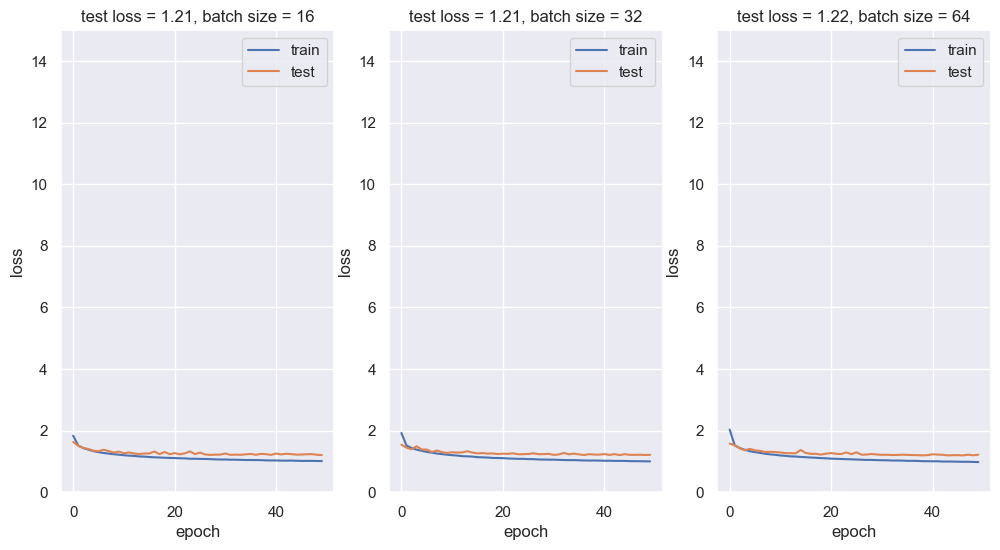

In [9]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

The setting with a batch-size of 16 led to the best results (or atleast the same as batch-size 32). Therefore the model was now trained with a batchsize of 16. Then the trained model is saved to a local file. The filepath given in the tutorial needed to be adjusted, because there was an error.

In [10]:
# Save the trained model
filepath = "best_weights.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

To evaluate the model was used to make predictions. To visualize the predictions, the predicted values are plotted vs. the true pIC50 values on the test set in a scatter plot.

Evaluate the model on the test data
 loss: 1.19
 mse (same as loss): 0.83
 mae: 1.19
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
6.67
7.63
6.25
8.17
7.16


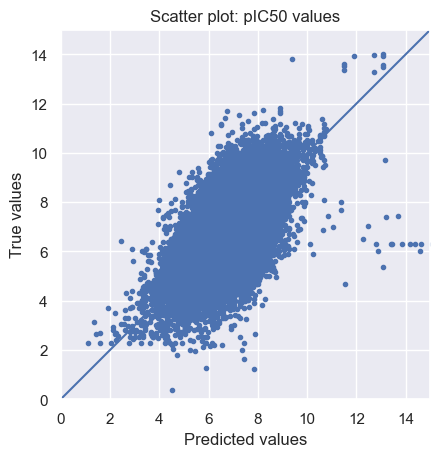

In [11]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

As we have no additional data to make predictions using the trained model the tutorial ends here.